# Tutorial: Running linear mixed effects models

This lab delves into mixed-effects models and their implementation in R.

## Goals:
* Learn how to use the `lmer()` function


This tutorial draws from Chapter 1 in Bates, D., Maechler, M., Bolker, B., & Walker, S. (2014). "lme4: Linear mixed-effects models using Eigen and S4". R package version:, 1(7), 1-23.

---
# Linear mixed-effects models

Linear mixed-effects models let you account for correlations among your observations and variation due to variables other than those of interest (like *participant* or *classroom*). Let's see how we can use the linear mixed-effects tools in R. 

To get started, we will need to install the [lme4](https://cran.r-project.org/web/packages/lme4/lme4.pdf) library in R. 

In [ ]:
# Install LME4
#install.packages("lme4") # Uncomment if not installed.
library(lme4)
library(ggplot2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: Matrix



This library includes a sleep study experiment that we will use to practice fitting a mixed-effect model.

In [ ]:
#help(sleepstudy) # Uncomment to see documentation
head(sleepstudy)

,Reaction,Days,Subject
,<dbl>,<dbl>,<fct>
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308
6,414.6901,5,308


Summary: "The average reaction time per day for subjects in a sleep deprivation study. On day 0 the subjects had their normal amount of sleep. Starting that night they were restricted to 3 hours of sleep per night. The observations represent the average reaction time on a series of tests given each day to each subject."

So we have a data frame with 180 observations on the following 3 variables.

* **Reaction:** Average reaction time (ms)

* **Days:** Number of days of sleep deprivation

* **Subject:**  Subject number on which the observation was made.

The main question we have here is whether days of consecutive sleep deprivation impact reaction times.  This boils down to a repeated measures problem: the same subjects are tested across multiple days, so random effects associated with each individual will also carry over across days, violating the assumption that each observation is independent and identically distributed (i.e., *iid*).



`geom_smooth()` using formula 'y ~ x'



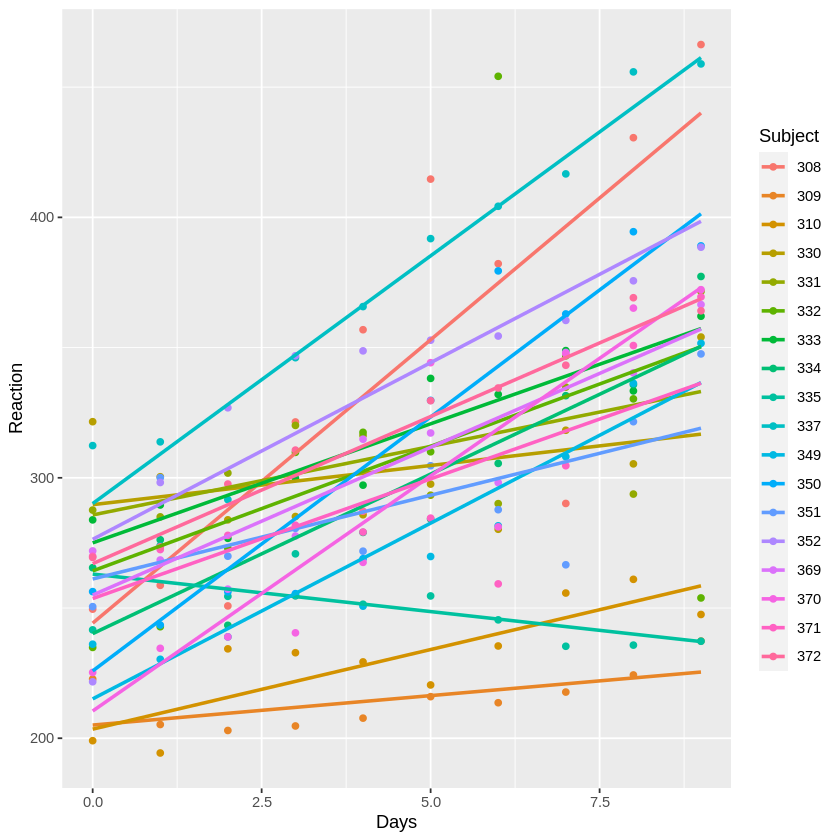

In [ ]:
# Let's take a look at the fixed effects
# we can plot the data by days and then grouped by subjects
ggplot(sleepstudy, aes(Days, Reaction, color = Subject)) + 
  geom_point() + geom_smooth(method="lm",se=FALSE)
# What assumption in a regression model are we violating? 

Note that not only do individual subjects' baseline RTs differ, but the rates at which their RTs change with days of little sleep differ. Put another way: subjects have different reaction speeds, and they're also differently affected by lack of sleep. 

*Tangent: I knew a guy who was like subject 335 once. He seemed to thrive on lack of sleep.*

In [ ]:
# First let's try the simple linear fit anyways and see what we get
fe.fit = lm(Reaction~Days, data=sleepstudy)
summary(fe.fit)


Call:
lm(formula = Reaction ~ Days, data = sleepstudy)

Residuals:
     Min       1Q   Median       3Q      Max 
-110.848  -27.483    1.546   26.142  139.953 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  251.405      6.610  38.033  < 2e-16 ***
Days          10.467      1.238   8.454 9.89e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 47.71 on 178 degrees of freedom
Multiple R-squared:  0.2865,	Adjusted R-squared:  0.2825 
F-statistic: 71.46 on 1 and 178 DF,  p-value: 9.894e-15


Even though we're ignoring the role of subjects in the example above, we still get a significant effect of days of sleep deprivation on reaction time.

However, in order to account for those subject effects, let's treat them as a random effect. In this case we will assume that the effect of sleep deprivation on reaction times varies by subject. 

In `lmer`, random-effects terms are distinguished by vertical bars (|) separating expressions for design matrices from grouping factors. 

Some notes on usage for the random effects terms: 

1. If you just want to find the subject intercepts (i.e., you care about subject differences in starting reaction times but not about how each subjects' RTs change as `Days` increases), then write the random effects term as `(1 | Subject)`.

2. If you want both the intercept *and* the slopes, you can write either `(1+Days | Subject)`  or `(Days | Subject)`. In the second case, the "1+" is inferred since usually if the analyst wants slopes they also want intercepts. 

3. If you want *just the slopes*, you can write `(0+Days | Subject)`. 

Given the plot above, I think we need to care about both intercepts and slopes. But to be sure, let's try it both ways. 

In [ ]:
# Now let's account for the random impact of subject variance on the model
me.fit1 = lmer(Reaction ~ Days + (Days | Subject), data=sleepstudy) # subject intercepts and slopes
# ^^ the same as me.fit1 = lmer(Reaction ~ Days +  (1+Days | Subject), data=sleepstudy) 
me.fit2 = lmer(Reaction ~ Days + (1 | Subject), data=sleepstudy) # only subject intercepts
print("*******me.fit1********")
summary(me.fit1)
print("*******me.fit2********")
summary(me.fit2)

[1] "*******me.fit1********"


Linear mixed model fit by REML ['lmerMod']
Formula: Reaction ~ Days + (Days | Subject)
   Data: sleepstudy

REML criterion at convergence: 1743.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9536 -0.4634  0.0231  0.4634  5.1793 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 Subject  (Intercept) 612.10   24.741       
          Days         35.07    5.922   0.07
 Residual             654.94   25.592       
Number of obs: 180, groups:  Subject, 18

Fixed effects:
            Estimate Std. Error t value
(Intercept)  251.405      6.825  36.838
Days          10.467      1.546   6.771

Correlation of Fixed Effects:
     (Intr)
Days -0.138

[1] "*******me.fit2********"


Linear mixed model fit by REML ['lmerMod']
Formula: Reaction ~ Days + (1 | Subject)
   Data: sleepstudy

REML criterion at convergence: 1786.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2257 -0.5529  0.0109  0.5188  4.2506 

Random effects:
 Groups   Name        Variance Std.Dev.
 Subject  (Intercept) 1378.2   37.12   
 Residual              960.5   30.99   
Number of obs: 180, groups:  Subject, 18

Fixed effects:
            Estimate Std. Error t value
(Intercept) 251.4051     9.7467   25.79
Days         10.4673     0.8042   13.02

Correlation of Fixed Effects:
     (Intr)
Days -0.371

The random effects: `(Days | Subject)`  allows individual subjects to vary randomly in terms of their intercept (starting reaction time) and for each person, the effect of the number of days of sleep lost on reaction time is estimated (reaction time change over days, also called a “random slope”).

If we look at the t-value for Days on Reaction in the Fixed effects of `me.fit1`, it has dropped to 6.77 (from 8.45 in the simple linear model). Thus we are getting a more conservative model fit on the fixed effects.

Notice that the report on the random effects doesn't provide an inferential statistic (i.e., a t-value). That is because interpreting the magnitude of the random effect is meaningless because we defined those effects as tangential (irrelevant) to the fixed effect that we are looking for. We are not looking for how variability in individuals changes the effect of sleep loss over time or at individual differences in the baseline reaction times. Instead, we are trying to estimate the fixed effects, taking into account this random variation.  

Therefore, to interpret the value of including the random effects term in your model, you will want to do a model comparison instead. Specifically, you might want to test whether the mixed-effect model provides a better fit to the data than the simple linear regression model.  

Remember the bias-variance tradeoff, and how a more complex model will generally provide a better fit? These three models have different model complexities, so you'll have to use an evaluation criterion that takes complexity into account (e.g., AIC). For now you can think of the AIC as quanitifying the amount of information lost or the variance unexplained (so a lower score would be better). 

In [ ]:
# We will compare the two models using the Akaike information criterion (AIC)
ic = AIC(fe.fit, me.fit1, me.fit2)
ic
diff(ic$AIC)

,df,AIC
,<dbl>,<dbl>
fe.fit,3,1906.293
me.fit1,6,1755.628
me.fit2,4,1794.465


[1] -150.66478   38.83681

As you might have expected, `me.fit1` has the lowest AIC, and so seems to be the best model choice for the data. The difference in AIC between `fe.fit` and the other two models is quite big, which means that the mixed-effects models account for substantially more variance in reaction time than the simple linear model, even after accounting for increased complexity.

*Notebook authored by Ven Popov, and edited by Krista Bond, Charles Wu, Patience Stevens, and Amy Sentis.*